In [1]:
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from matplotlib.font_manager import FontProperties
import math
import pandas as pd
import pickle
from pytrends.request import TrendReq
import seaborn as sns

In [2]:
with open('keywords.txt', 'r') as kw:
    search_terms = kw.readlines()
    search_terms = sorted([s.strip() for s in search_terms])

def query_google(search_terms, fname):        
    time_query = {}
        
    for term in search_terms:
        trends = TrendReq()
        trends.build_payload(kw_list=[term], timeframe='2011-01-01 2015-12-31')
        time_query[term] = trends.interest_over_time()
    query = {}
    
    for key, val in time_query.items():
        assert val.isPartial.sum() == 0, "There are partial results in {}".format(key)
        query[key] = val[key]
        
    df = pd.concat(query, axis=1)
    
    with open(fname, 'wb') as temporal:
        pickle.dump(df, temporal)
    
    return df

In [3]:
try:
    with open('temporal.obj', 'rb') as temp:
        df = pickle.load(temp)
except FileNotFoundError as exe:
    print("No data found. Querying Google Now")
    df = query_google(search_terms, 'temporal.obj')

In [4]:
def make_figure(in_frame, split_at=None, title='Article View Trends', keyword='views', subplot_objs=None, trend_only=False):
    """
    Takes the input data and creates a plot similar to figure 3 in the paper.
    :param dataframe: A pandas data frame with the dates (dtype=PeriodIndex) as index and views as its only column
    :param split_at: The date at which the data shall be split
    :param title: Figure title
    :return: Plots the figure
    """
    
    # Prepare the dataframe for seaborn (https://stackoverflow.com/questions/52112979/having-xticks-to-display-months-in-a-seaborn-regplot-with-pandas)
    # Seaborn has issues handling datetimes, so for the computation they are transformed to integers before transforming them back for the labelling later on.
    # Matplotlib provides the necessary functionality.
    dataframe = in_frame.copy()
    dataframe.index = dataframe.index.to_timestamp()
    dataframe['date_ordinal'] = mdates.date2num(dataframe.index)
    
    # Some color definition for plotting and the legend
    colors = {'Monthly Page Views': 'blue', 'trend': 'grey'}
    
    # Starting to build the actual plot
    if subplot_objs is None:
        fig, ax = plt.subplots(figsize=[18, 6])
    else:
        fig, ax = subplot_objs
        
    if split_at is None:  # Just a simple regplot
        sns.regplot(x='date_ordinal', y=keyword, data=dataframe, ax=ax, color=colors['Monthly Page Views'])
    else:  # Splitting at a given date to create two trend lines within one plot as in the paper.
        colors['Prism Disclosure, 6/6/2013'] = 'red'
        df1 = dataframe.loc[dataframe.index < split_at]
        df2 = dataframe.loc[dataframe.index >= split_at]
        sns.regplot(x='date_ordinal', y=keyword, data=df1, ax=ax, color=colors['Monthly Page Views'],
                    scatter_kws={'color': colors['Monthly Page Views'], 's': 30},
                    line_kws={'color': colors['trend']})
        sns.regplot(x='date_ordinal', y=keyword, data=df2, ax=ax, color=colors['Monthly Page Views'],
                    scatter_kws={'color': colors['Monthly Page Views'], 's': 30},
                    line_kws={'color': colors['trend']})
        ax.vlines(mdates.date2num(split_at), 0, 1, color=colors['Prism Disclosure, 6/6/2013'], transform=ax.get_xaxis_transform(), label=split_at)
    
    # Formatting and Optics
    fig.patch.set_facecolor('lightgrey')
    if trend_only:
        ax.set_xlabel('')
        ax.set_ylabel('')
    else:
        fig.suptitle(title)
        ax.set_xlabel('Month / Year')
        ax.set_ylabel('Monthly Page Views')
    ax.set_xlim(dataframe['date_ordinal'].min() - 15, dataframe['date_ordinal'].max() + 15)
    
    if not trend_only:
        # As mentioned above, the date was transformed to integers for the sake of plotting it using seaborn.
        # Now, they have to be transformed back to have nice x-Axis labels that are human-readable
        loc = mdates.MonthLocator()
        ax.xaxis.set_major_locator(loc)
        ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(loc))
    
        # Add a custom legend
        legend_patches = []
        for entry, c in colors.items():
            legend_patches.append(mpatches.Patch(color=c, label=entry))
        legend_patches.append(mpatches.Patch(color='lightgrey', label='95% Confidence Interval'))
        font = FontProperties()
        font.set_size('large')
        fig.autofmt_xdate(rotation=60)
        plt.legend(handles=legend_patches, title='Legend', bbox_to_anchor=(0, 0), loc='lower left', prop=font,
                   ncol=len(legend_patches) // 2, fancybox=True, shadow=True)

## Exploring the Wikipedia Data

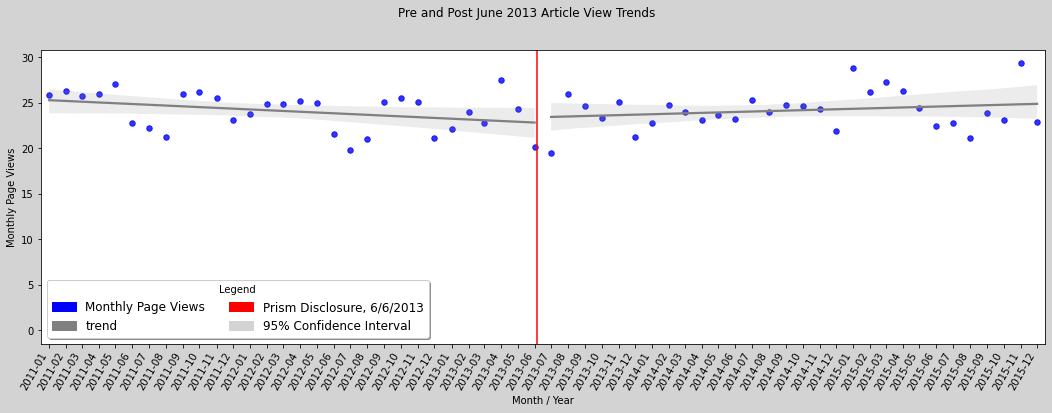

In [5]:
df_plot = pd.DataFrame({'Interest': df.mean(axis=1), 'SDate': df.index.to_period('M')})
monthly_views = df_plot.groupby('SDate').mean()  # Get monthly views
make_figure(monthly_views, split_at=datetime.datetime(2013, 6, 6), title='Pre and Post June 2013 Article View Trends', keyword='Interest')

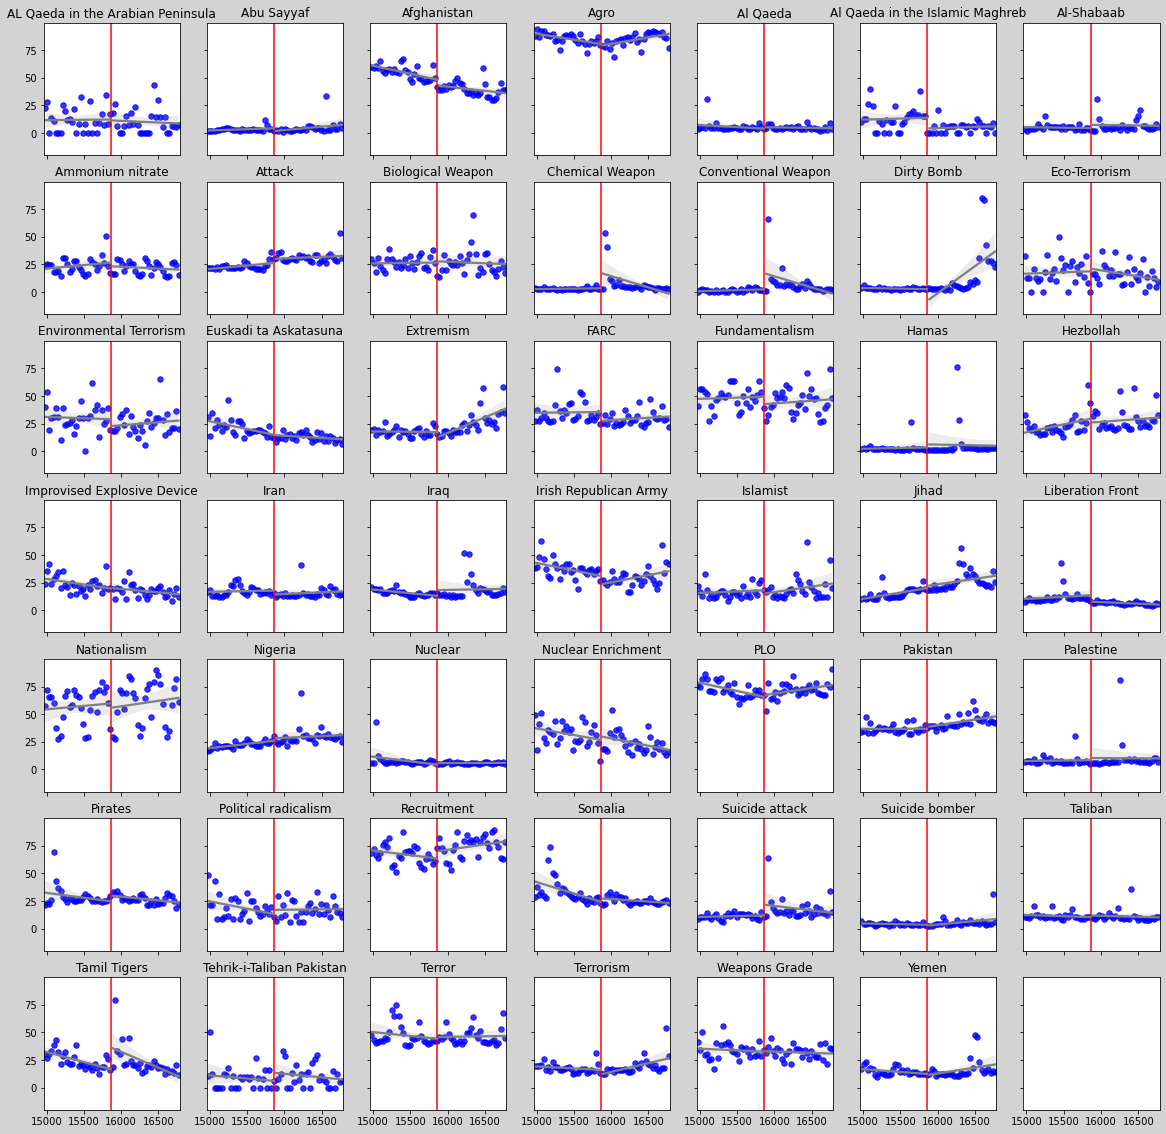

In [6]:
COLUMNS = math.ceil(math.sqrt(len(search_terms)))
ROWS = math.ceil(len(search_terms) / COLUMNS)
fig, axs = plt.subplots(nrows=ROWS, ncols=COLUMNS, figsize=[20, 20], sharex=True, sharey=True)

df['SDate'] = df.index.to_period('M')
for i, title in enumerate(search_terms):
    sub_df = df[[title, 'SDate']]
    sub_df = sub_df.groupby('SDate').mean()
    
    row = i // ROWS
    col = i % ROWS
    axis = axs[row, col]
    axis.set_title(title)
    
    make_figure(sub_df, split_at=datetime.datetime(2013, 6, 6), title=title, keyword=title, subplot_objs=(fig, axis), trend_only=True)

In [7]:
fig.savefig('grid.png')